In [1]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from utilis import get_dataset
import matplotlib.pyplot as plt

2023-12-14 16:05:18.487824: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 16:05:18.546902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 16:05:18.546991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 16:05:18.548758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 16:05:18.558116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 16:05:18.559500: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
model = tf.keras.models.load_model('model_75.keras')

In [3]:
df, scale_max, scale_min = get_dataset(mode='predict', horizon=5, number_lags=75)
predicts = model.predict(tf.convert_to_tensor(df.drop('close', axis=1).values))

/workspaces/OEOD-/SUP/utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
/workspaces/OEOD-/SUP/utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
/workspaces/OEOD-/SUP/utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

38/38 [==============================] - 5s 94ms/step


In [31]:
portfolio = pd.DataFrame()
portfolio['close'] = df['close'].apply(lambda x: x * (scale_max - scale_min) + scale_min)
portfolio['predicted_5_close'] = predicts[:, -1]
portfolio['predicted_5_close'] = portfolio['predicted_5_close'].apply(lambda x: x * (scale_max - scale_min) + scale_min)
portfolio['estimated_differece'] = portfolio['predicted_5_close'] - portfolio['close']
portfolio['q90'] = portfolio['estimated_differece'].apply(lambda x: True if x > portfolio['estimated_differece'].quantile(0.95) else False)
portfolio['q5'] = portfolio['estimated_differece'].apply(lambda x: True if x < portfolio['estimated_differece'].quantile(0.05) else False)
portfolio['returns'] = portfolio['close'].pct_change() 
portfolio = portfolio.dropna()


def calculate_percentage_change(old_value, new_value):
    if old_value == 0:
        return np.nan
    else:
        return (new_value - old_value) / old_value * 100

buy_hold = calculate_percentage_change(portfolio['close'].values[0], portfolio['close'].values[-1]) * 10000 * 0.01 + 10000

buy_hold


13824.346912715628

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


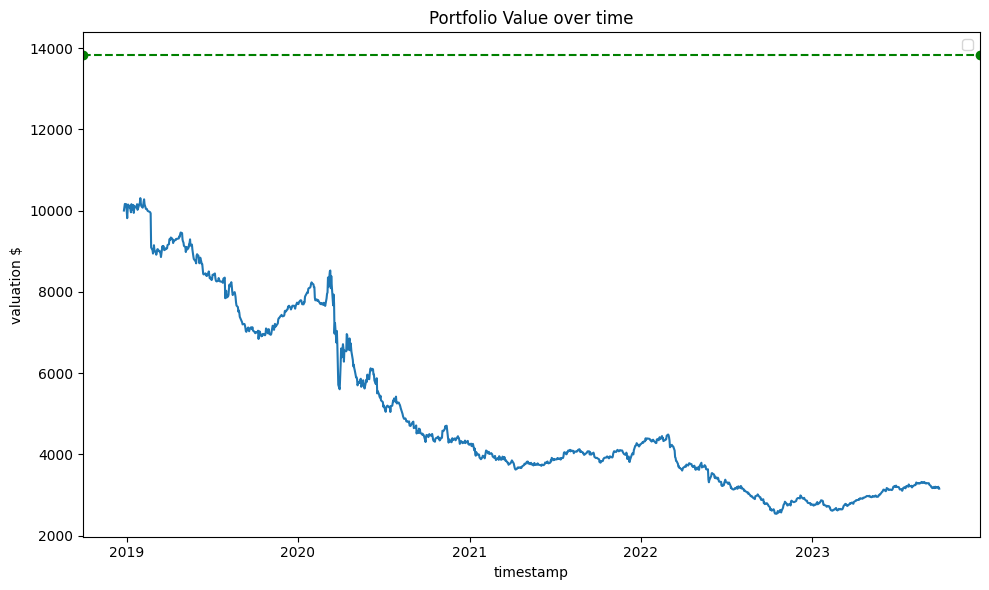

In [34]:
# Naive strategy
action = 0
portfolio_returns = portfolio['returns'].values.tolist()
for index in range(len(portfolio_returns)):
    action = 1 if portfolio['estimated_differece'].values[index] >= 0 else -1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['naive_strategy'] = portfolio_returns
x = portfolio['naive_strategy'].index
y = portfolio['naive_strategy'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time")
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


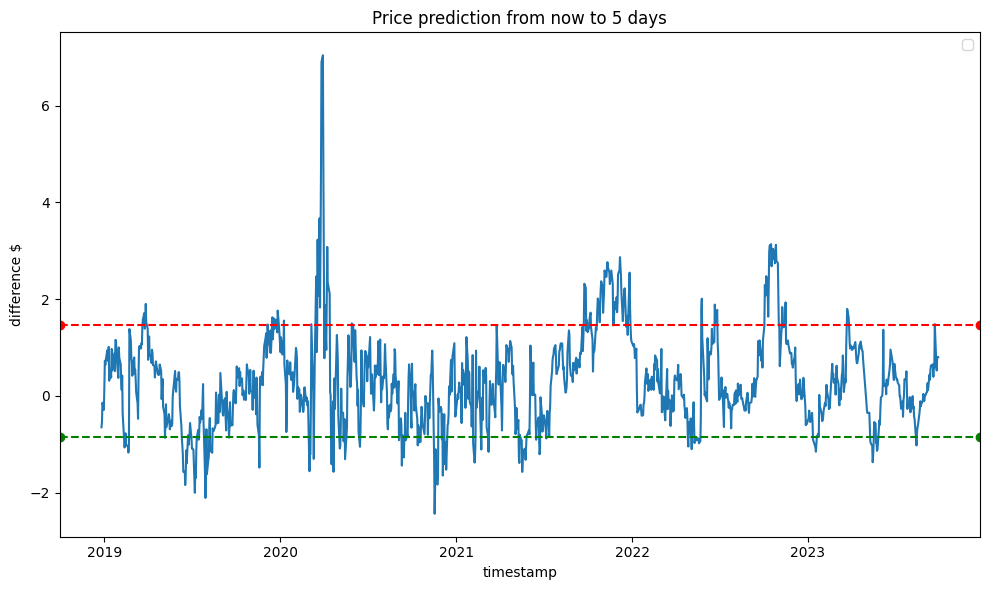

In [36]:
x = portfolio['naive_strategy'].index
y = portfolio['estimated_differece'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=portfolio['estimated_differece'].quantile(0.1), color='green', linestyle='--', marker='o')
plt.axhline(y=portfolio['estimated_differece'].quantile(0.9), color='red', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("difference $")
plt.title("Price prediction from now to 5 days")
plt.legend()
plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


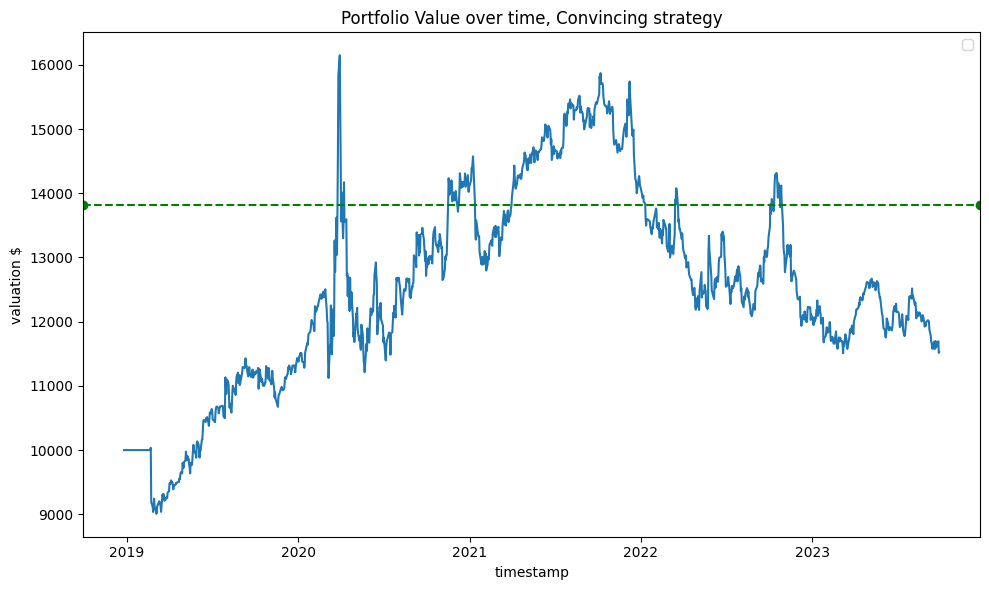

In [37]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()
action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q90'].values[index] == True:
        action = -1
    if portfolio['q5'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time, Convincing strategy")
plt.legend()
plt.tight_layout()
plt.show()